##Импортируем нужные модули

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Подключаем Google диск

In [11]:
from google.colab import drive
import pathlib

drive.mount('/content/drive')

dataset_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_photos')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Выводим кол-во. изображений в датасете

In [12]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 4605


## Создаем датасеты и кэшируем их

In [13]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 4605 files belonging to 10 classes.
Using 3684 files for training.
Found 4605 files belonging to 10 classes.
Using 921 files for validation.
Class names: ['Daisy', 'Dandelion', 'Nasturtium', 'Passionflower', 'Plumeria', 'Roses', 'Sunflowers', 'Tulips', 'WaterLily', 'Сyclamen']


## Создаем модель, компилируем её и выводим summary

In [14]:
# create model
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

##Обучаем нейросеть и выводим графики точности


Epoch 1/10
113/113 [==============================] - 424s 810ms/step - loss: 1.5589 - accuracy: 0.4147 - val_loss: 1.2363 - val_accuracy: 0.5310
Epoch 2/10
113/113 [==============================] - 2s 21ms/step - loss: 1.0759 - accuracy: 0.6149 - val_loss: 1.1417 - val_accuracy: 0.5754
Epoch 3/10
113/113 [==============================] - 2s 21ms/step - loss: 0.7942 - accuracy: 0.7209 - val_loss: 1.0638 - val_accuracy: 0.6109
Epoch 4/10
113/113 [==============================] - 2s 21ms/step - loss: 0.5142 - accuracy: 0.8178 - val_loss: 1.0868 - val_accuracy: 0.6330
Epoch 5/10
113/113 [==============================] - 2s 21ms/step - loss: 0.3049 - accuracy: 0.8948 - val_loss: 1.1783 - val_accuracy: 0.6231
Epoch 6/10
113/113 [==============================] - 2s 21ms/step - loss: 0.1841 - accuracy: 0.9408 - val_loss: 1.4009 - val_accuracy: 0.6142
Epoch 7/10
113/113 [==============================] - 2s 20ms/step - loss: 0.0915 - accuracy: 0.9743 - val_loss: 1.4889 - val_accuracy: 0.6

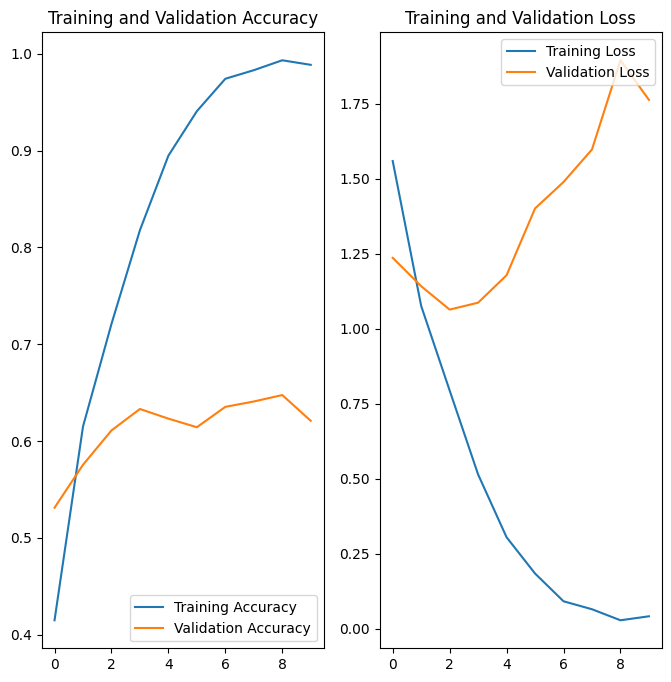

In [ ]:
# train the model
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Решение проблемы переобучения.
##Добавляем аугментацию и регуляризацию (Dropout)

In [ ]:
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_4 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 random_contrast_4 (RandomC  (None, 180, 180, 3)       0         
 ontrast)                                                        
                                                                 
 conv2d_27 (Conv2D)          (None, 180, 180, 16)     

##Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох обучения

Epoch 1/20
113/113 [==============================] - 6s 31ms/step - loss: 1.7156 - accuracy: 0.3596 - val_loss: 1.4856 - val_accuracy: 0.4612
Epoch 2/20
113/113 [==============================] - 3s 29ms/step - loss: 1.3253 - accuracy: 0.5177 - val_loss: 1.2569 - val_accuracy: 0.5322
Epoch 3/20
113/113 [==============================] - 3s 29ms/step - loss: 1.1704 - accuracy: 0.5778 - val_loss: 1.1681 - val_accuracy: 0.5831
Epoch 4/20
113/113 [==============================] - 3s 31ms/step - loss: 1.0783 - accuracy: 0.6149 - val_loss: 1.1656 - val_accuracy: 0.5876
Epoch 5/20
113/113 [==============================] - 3s 29ms/step - loss: 1.0115 - accuracy: 0.6351 - val_loss: 1.0679 - val_accuracy: 0.6075
Epoch 6/20
113/113 [==============================] - 3s 29ms/step - loss: 0.9208 - accuracy: 0.6681 - val_loss: 0.9164 - val_accuracy: 0.6475
Epoch 7/20
113/113 [==============================] - 3s 30ms/step - loss: 0.8946 - accuracy: 0.6800 - val_loss: 0.9129 - val_accuracy: 0.6729

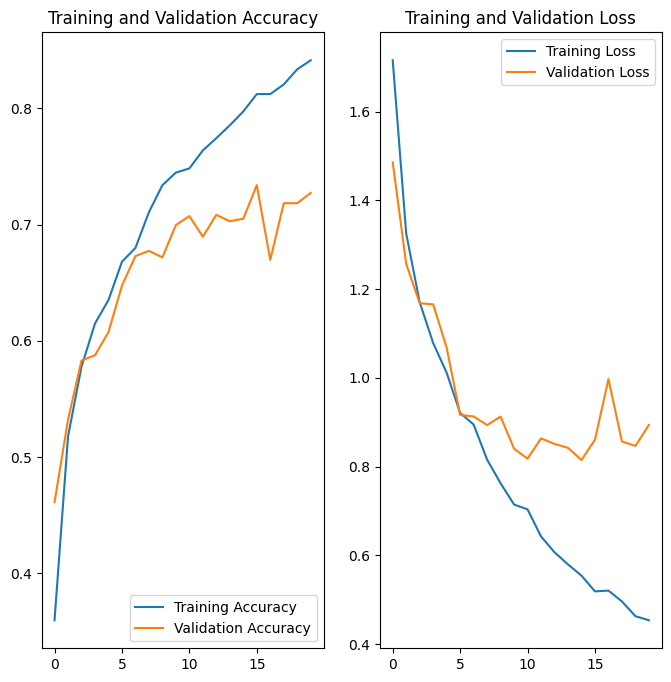

In [ ]:
# train the model
epochs = 20 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Делаем инференс на новом изображении

In [9]:
# load image
sunflower_url = "https://mykaleidoscope.ru/uploads/posts/2022-06/1656067107_51-mykaleidoscope-ru-p-roza-takazi-krasivo-foto-51.jpg"
sunflower_path = tf.keras.utils.get_file('mykaleidoscope.jpg', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
img.show()

1/1 [==============================] - 0s 262ms/step
На изображении скорее всего Roses (99.84% вероятность)


##Экспорт файла модели (скачать себе на компьютер)

In [ ]:
from google.colab import files

model_file_name = "my_flowers_model.h5"

# save model
model.save(model_file_name)

# download model
files.download(model_file_name)